# Miniproject 1: Classification and Regression
## Romain Loiseau

### 1- Getting started

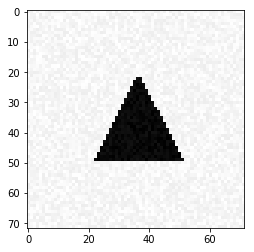

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.python.keras.utils import to_categorical

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(str(i) + "-", end='')
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    print("done")
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0, verbose = True):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    if(verbose):print('Creating data:')
    for i in range(nb_samples):
        if verbose and i % 100 == 0:
            print(str(i) + "-", end='')
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    if(verbose):print("done")
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

### 3- Simple classification

In [2]:
from tensorflow.python.keras.utils import to_categorical

[X_train, Y_train] = generate_dataset_classification(300, 20)

Y_train = to_categorical(Y_train)

dict_classes = {0 : "rectangle", 1 : "disk", 2 : "triangle"}

Creating data:
0-100-200-done


In [2]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

def build_regression(optimizer = "sgd", input_shape = 5184, output_shape = 3):
    
    features = Input((input_shape, ), name = "input_features")
    
    output = Dense(output_shape, activation = "softmax", name = "output")(features)
    
    model = Model(inputs = features, outputs = output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    
    return model

In [3]:
def test(model, dict_classes, n = 100):
    [X_train, Y_train] = generate_dataset_classification(n, 20)
    Y_pred = np.argmax(model.predict(X_train), axis = -1).astype(int)
    
    array = np.zeros((3, 3))
    for i in range(n):
        array[int(Y_train[i]), Y_pred[i]] += 1
    print("Confusion matrix with n = " + str(n) + " samples")
    print(array / n)

### 4- Visualization of the Solution

In [4]:
def showWeights(model):
    for w in model.get_weights():
        if(w.shape[0] == (72 * 72)):
            w_ = ((w - np.min(w)) / (np.max(w) - np.min(w))).reshape(72,72, -1)
            for i in range(3):
                plt.subplot(131 + i)
                plt.imshow(w_[:, :, i], cmap = "gray")
                plt.title(dict_classes[i] + " filter")
                plt.axis("off")
            plt.show()

In [5]:
def showHistory(history):
    history_dict= history.history
    epochs = np.arange(len(history_dict["loss"]))
    if("acc" in history_dict.keys()):
        plt.subplot(121)
    plt.plot(epochs, history_dict["loss"], label = "train")
    if("val_loss" in history_dict.keys()):
        plt.plot(epochs, history_dict["val_loss"], label = "test")
    plt.legend(loc = "best")
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    if("acc" in history_dict.keys()):
        plt.subplot(122)
        plt.plot(epochs, history_dict["acc"], label = "train")
        if("val_acc" in history_dict.keys()):
            plt.plot(epochs, history_dict["val_acc"], label = "test")
        plt.legend(loc = "best")
        plt.title("accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
    plt.show()

In [6]:
def run(optimizer, modelname, X_train, Y_train, validation_data = None, epochs = 50, batch_size = 32, showweights = True, testnewdata = True, verbose = 0):
    print("####################" + len(optimizer) * "#")
    print("### Optimizer : " + optimizer + " ###")
    print("####################" + len(optimizer) * "#")
    if(modelname == "build_regression"):
        model = build_regression(optimizer = optimizer)
    elif(modelname == "build_convolutionnal"):
        model = build_convolutionnal(optimizer = optimizer)
    elif(modelname == "build_cornerfinder"):
        model = build_cornerfinder(optimizer = optimizer)
    elif(modelname == "build_denoiser"):
        model = build_denoiser(optimizer = optimizer)
    else:
        raise ValueError("Invalid modelname : " + str(modelname))
        
    model.summary()
    
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data = validation_data, verbose = verbose)
    
    if(showweights):showWeights(model)
    showHistory(history)
    if(testnewdata):test(model, dict_classes)
    print()
    return model

#######################
### Optimizer : sgd ###
#######################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


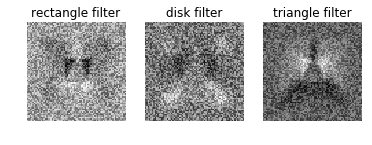

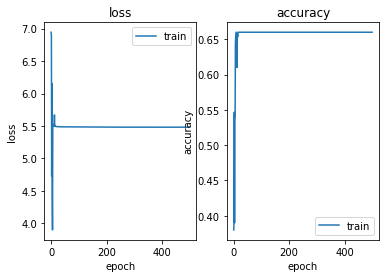

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.36 0.   0.  ]
 [0.29 0.   0.  ]
 [0.   0.   0.35]]

########################
### Optimizer : adam ###
########################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


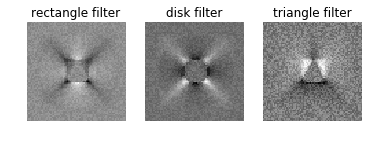

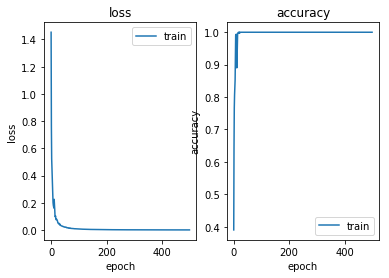

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.23 0.   0.  ]
 [0.   0.49 0.  ]
 [0.   0.   0.28]]



In [8]:
for optimizer in ["sgd", "adam"]:
    run(optimizer, "build_regression", X_train, Y_train, epochs = 500)

On remarque donc que l'optimiseur "SGD" à tendance à tomber dans un minima local, ce que ne fait pas l'optimiseur "ADAM". Cela peut être expliqué par le fait que l'optimiseur "ADAM" fonctionne avec des moments d'ordre deux, ce qui peut prévenir des minimas locaux.

### 5- A More Difficult Classification Problem

Creating data:
0-100-200-300-400-500-600-700-800-900-1000-1100-1200-1300-1400-1500-1600-1700-1800-1900-2000-2100-2200-2300-2400-2500-2600-2700-2800-2900-done
Creating data:
0-100-200-done
#######################
### Optimizer : sgd ###
#######################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


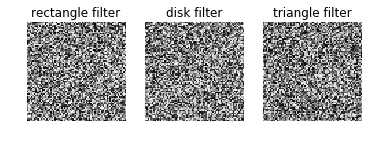

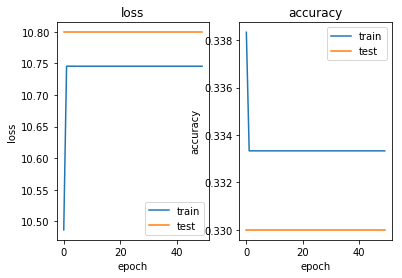

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.   0.32 0.  ]
 [0.   0.36 0.  ]
 [0.   0.32 0.  ]]

########################
### Optimizer : adam ###
########################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


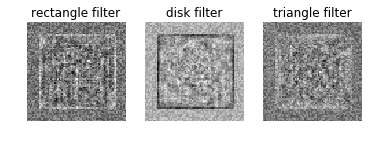

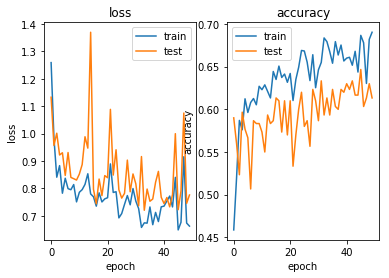

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.17 0.03 0.12]
 [0.06 0.01 0.29]
 [0.16 0.04 0.12]]



In [9]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
[X_test, Y_test] = generate_test_set_classification()
Y_train = to_categorical(Y_train)

for optimizer in ["sgd", "adam"]:
    run(optimizer, "build_regression", X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50)

On se rend donc compte que dans ce cas, on ne trouve plus de minima avec ce réseau. On essaye donc avec une réseau convolutionnel.

In [10]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Reshape

def build_convolutionnal(optimizer = "sgd", input_shape = 5184, output_shape = 3):
    
    features = Input((input_shape, ), name = "input_features")
    shape = int(input_shape**0.5)
    reshaped = Reshape((shape, shape, 1))(features)
    
    conv00 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(reshaped)
    conv01 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv00)
    pool0 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(pool0)
    conv11 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv10)
    pool1 = MaxPooling2D((2, 2))(conv11)
    
    conv20 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(pool1)
    conv21 = Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv20)
    pool2 = MaxPooling2D((2, 2))(conv21)
    
    flat = Flatten()(pool2)
    
    dense0 = Dense(256, activation = "relu")(flat)
    dense1 = Dense(128, activation = "relu")(dense0)
    output = Dense(output_shape, activation = "softmax", name = "output")(dense1)
    
    model = Model(inputs = features, outputs = output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    
    return model

Creating data:
0-100-200-300-400-500-600-700-800-900-1000-1100-1200-1300-1400-1500-1600-1700-1800-1900-2000-2100-2200-2300-2400-2500-2600-2700-2800-2900-done
Creating data:
0-100-200-done
#######################
### Optimizer : sgd ###
#######################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
______________

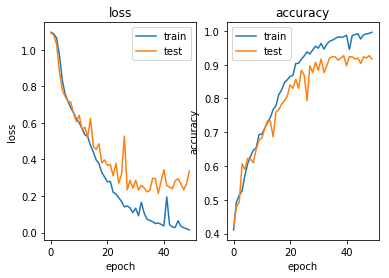

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.29 0.03 0.  ]
 [0.   0.36 0.  ]
 [0.   0.06 0.26]]

########################
### Optimizer : adam ###
########################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)

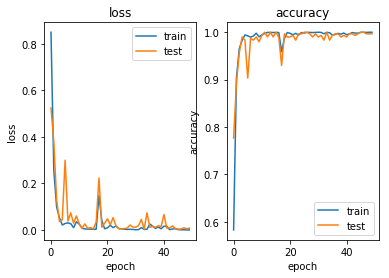

Creating data:
0-done
Confusion matrix with n = 100 samples
[[0.32 0.   0.  ]
 [0.   0.36 0.  ]
 [0.   0.   0.32]]



In [11]:
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
[X_test, Y_test] = generate_test_set_classification()
Y_train = to_categorical(Y_train)

for optimizer in ["sgd", "adam"]:
    run(optimizer, "build_convolutionnal", X_train, Y_train, validation_data = (X_test, Y_test))

On remarque donc que l'optimiseur "SGD" à tendance à légèrement overfitter, ce que ne fait pas l'optimiseur "ADAM". Cela peut être expliqué par le fait que l'optimiseur "ADAM" fonctionne avec des moments d'ordre deux.

### 5- A Regression Problem

Creating data:
0-100-200-300-400-500-600-700-800-900-1000-1100-1200-1300-1400-1500-1600-1700-1800-1900-2000-2100-2200-2300-2400-2500-2600-2700-2800-2900-3000-3100-3200-3300-3400-3500-3600-3700-3800-3900-4000-4100-4200-4300-4400-4500-4600-4700-4800-4900-5000-5100-5200-5300-5400-5500-5600-5700-5800-5900-6000-6100-6200-6300-6400-6500-6600-6700-6800-6900-7000-7100-7200-7300-7400-7500-7600-7700-7800-7900-8000-8100-8200-8300-8400-8500-8600-8700-8800-8900-9000-9100-9200-9300-9400-9500-9600-9700-9800-9900-10000-10100-10200-10300-10400-10500-10600-10700-10800-10900-11000-11100-11200-11300-11400-11500-11600-11700-11800-11900-12000-12100-12200-12300-12400-12500-12600-12700-12800-12900-13000-13100-13200-13300-13400-13500-13600-13700-13800-13900-14000-14100-14200-14300-14400-14500-14600-14700-14800-14900-15000-15100-15200-15300-15400-15500-15600-15700-15800-15900-16000-16100-16200-16300-16400-16500-16600-16700-16800-16900-17000-17100-17200-17300-17400-17500-17600-17700-17800-17900-18000-18100-18200

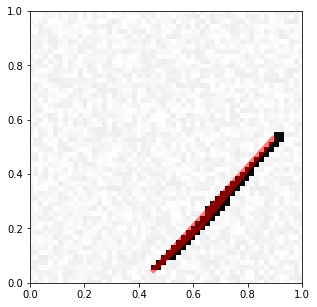

Creating data:
0-100-200-done


In [8]:
[X_train, Y_train] = generate_dataset_regression(20000, 20)
visualize_prediction(X_train[0], Y_train[0])
[X_test, Y_test] = generate_test_set_regression()

In [9]:
def sortCorner(Y):
    Y = Y.reshape(-1, 3,2)
    yy = Y.transpose(1, 0, 2)
    yy = (yy - np.mean(yy, axis = 0)).transpose(1, 0, 2)
    yy = 180 * np.arctan2(yy[:, :, 0], yy[:, :, 1]) / np.pi
    yy += (yy < 0) * 360
    args = np.argsort(yy, axis = -1)
    Ye = np.array([y[arg] for y, arg in zip(Y, args)])
    return Ye

Y_train = sortCorner(Y_train).reshape(-1, 6)
Y_test = sortCorner(Y_test).reshape(-1, 6)

############################
### Optimizer : adadelta ###
############################
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_features (InputLayer)  (None, 5184)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 72, 72, 8)         80        
_________________________________________________________________
batch_normalization_72 (Batc (None, 72, 72, 8)         32        
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 72, 72, 8)         584       
_________________________________________________________________
batch_normalization_73 (Batc (None, 72, 72, 8)         32        
_______________________________________________________

20000/20000 [==============================] - 9s 463us/step - loss: 0.0033 - val_loss: 0.0168
Epoch 39/100
20000/20000 [==============================] - 9s 464us/step - loss: 0.0032 - val_loss: 0.0075
Epoch 40/100
20000/20000 [==============================] - 9s 463us/step - loss: 0.0032 - val_loss: 0.0097
Epoch 41/100
20000/20000 [==============================] - 9s 464us/step - loss: 0.0031 - val_loss: 0.0089
Epoch 42/100
20000/20000 [==============================] - 9s 462us/step - loss: 0.0031 - val_loss: 0.0091
Epoch 43/100
20000/20000 [==============================] - 9s 466us/step - loss: 0.0030 - val_loss: 0.0070
Epoch 44/100
20000/20000 [==============================] - 9s 462us/step - loss: 0.0029 - val_loss: 0.0208
Epoch 45/100
20000/20000 [==============================] - 9s 465us/step - loss: 0.0030 - val_loss: 0.0069
Epoch 46/100
20000/20000 [==============================] - 9s 462us/step - loss: 0.0028 - val_loss: 0.0102
Epoch 47/100
20000/20000 [===============

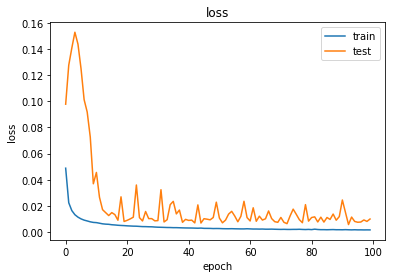


Test


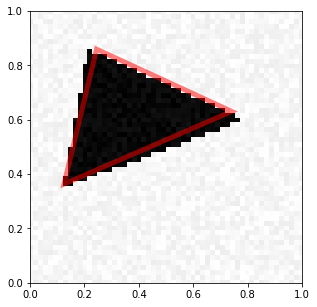

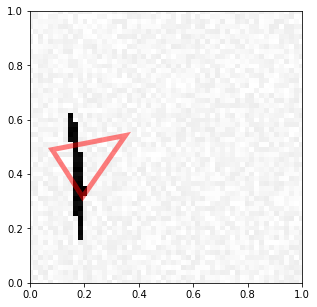

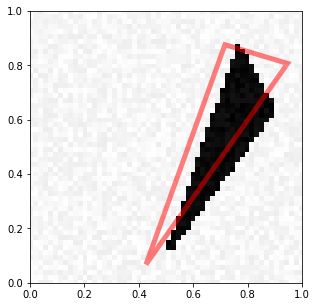

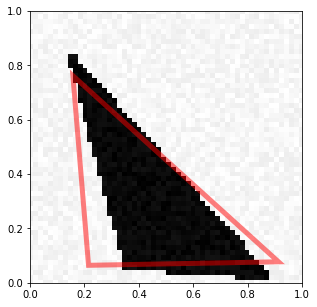

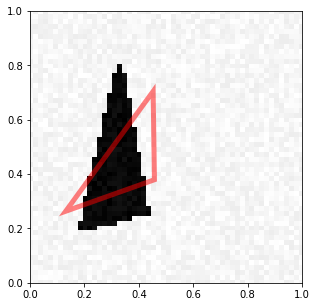

In [18]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Concatenate, BatchNormalization, UpSampling2D, Input, Dense, Reshape, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.losses import categorical_crossentropy

def build_cornerfinder(optimizer = "sgd", input_shape = 5184):
    
    features = Input((input_shape, ), name = "input_features")
    shape = int(input_shape**0.5)
    reshaped = Reshape((shape, shape, 1))(features)
    
    conv00 = BatchNormalization()(Conv2D(8, (3, 3), activation = "relu", padding = "same")(reshaped))
    conv01 = BatchNormalization()(Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv00))
    pool0 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(pool0))
    conv11 = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv10))
    pool1 = MaxPooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(pool1))
    conv21 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv20))
    pool2 = MaxPooling2D((2, 2))(conv21)
    
    conv30 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(pool2))
    conv31 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(conv30))
    pool3 = MaxPooling2D((2, 2))(conv31)
    
    flat = Flatten()(pool3)
    
    dense0 = BatchNormalization()(Dense(256, activation = "relu")(flat))
    dense1 = BatchNormalization()(Dense(128, activation = "relu")(dense0))
    output = Dense(6, activation = "sigmoid", name = "output")(dense1)
    
    model = Model(inputs = features, outputs = output)
    model.compile(optimizer=optimizer, loss="mse")
    
    return model

model = run("adadelta", "build_cornerfinder", X_train, Y_train,
            validation_data = (X_test, Y_test),
            epochs = 100, batch_size = 512, showweights = False, testnewdata = False, verbose = True)

nshow = 5 
preds_test = model.predict(X_test)
print("Test")
for i in range(nshow):
    ind = np.random.randint(len(X_test))
    visualize_prediction(X_test[ind], preds_test[ind])

On arrive donc à bien retrouver les coins, néanmoins, le réseau met du temps à converger, et demande beaucoup d'examples. Nous avons également essayés d'utiliser un batch generator, mais le temps de création des données ralentit trop l'entrainement pour que ce soit interessant.  


Nous avons egalement trouvés une implémentation qui, en résolvant un problème de classification, permet de mieux résoudre le problème. Le code est montré dans la suite mais n'est pas executé car il ne réponds pas à la question de la regression.

##### La partie qui suit est un test pour retrouver les coins grace à de la segmentation à l'aide d'un réseau de type Unet. Cela marche très bien, mais il faut ensuite faire tourner un algorithme de type Kmeans à trois centroids pour trouver les trois coins. Ce n'est peut être pas l'implémentation la plus pertinente (d'autant plus que la question s'intitule 'regression' ...)

```python
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Concatenate, BatchNormalization, UpSampling2D
from tensorflow.python.keras.losses import categorical_crossentropy
    
def encodeCorner(Y):
    Ye = np.zeros((Y.shape[0], 72, 72, 3))
    for i, y in enumerate(Y):
        for j in range(3):
            Ye[i][tuple(y[j])][j] = 1
    return Ye[:, :, ::-1, :].transpose(0, 2, 1, 3)

Y_train_c = encodeCorner((72 * Y_train.reshape(-1, 3,2)).astype(int))
Y_test_c = encodeCorner((72 * Y_test.reshape(-1, 3,2)).astype(int))

def build_cornerfinder(optimizer = "sgd", input_shape = 5184):
    
    features = Input((input_shape, ), name = "input_features")
    shape = int(input_shape**0.5)
    reshaped = Reshape((shape, shape, 1))(features)
    
    def my_init(shape, dtype, partition_info):
        lapl_array = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
        soblelx_array = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
        soblely_array = np.array([[-1, 0, 1], [-2, 0, -1], [-1, 0, 1]]) / 8
        
        array = np.array([lapl_array, soblelx_array, soblely_array]).transpose(1, 2, 0)
        array = np.expand_dims(array, 2)
        return K.variable(array)
    
    def my_categorical_crossentropy(y_true, y_pred):
        c0 = K.expand_dims(categorical_crossentropy(K.flatten(y_true[:, :, :, 0]), K.flatten(K.squeeze(y_pred, axis = -1))))
        c1 = K.expand_dims(categorical_crossentropy(K.flatten(y_true[:, :, :, 1]), K.flatten(K.squeeze(y_pred, axis = -1))))
        c2 = K.expand_dims(categorical_crossentropy(K.flatten(y_true[:, :, :, 2]), K.flatten(K.squeeze(y_pred, axis = -1))))
        c = K.concatenate([c0, c1, c2], axis = -1)
        m = K.mean(c)
        return m

    conv00 = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(reshaped))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv00))
    pool0 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(pool0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(conv10))
    pool1 = MaxPooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(pool1))
    conv21 = BatchNormalization()(Conv2D(128, (3, 3), activation = "relu", padding = "same")(conv20))
    conv22 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(conv21))
    
    up0 = Concatenate()([UpSampling2D((2, 2))(conv22), conv11])
    conv20u = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(up0))
    conv21u = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv20u))
    
    
    up1 = Concatenate()([UpSampling2D((2, 2))(conv21u), conv01])
    conv20u = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(up1))
    conv21u = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv20u))
    conv22u = BatchNormalization()(Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv21u))
    
    output = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(conv22u)
    
    
    
    model = Model(inputs = features, outputs = output)
    model.compile(optimizer=optimizer, loss=my_categorical_crossentropy)
    
    return model

for optimizer in ["sgd", "adam"][1:]:
    model = run(optimizer, "build_cornerfinder", X_train, Y_train_c,
                validation_data = (X_test, Y_test_c),
                epochs = 25, showweights = False, testnewdata = False, verbose = True)
    
nshow = 5

preds = model.predict(X_train[:nshow])

for i in range(nshow):
    plt.figure(figsize = (6, 2))
    plt.subplot(131)
    plt.imshow(X_train[i].reshape(72, 72), cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(Y_train_c[i], cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(preds[i, :, :, 0] > 0.25, cmap = "gray")
    plt.axis("off")
    plt.show()
    
preds = model.predict(X_test[:nshow])

for i in range(nshow):
    plt.figure(figsize = (6, 2))
    plt.subplot(131)
    plt.imshow(X_test[i].reshape(72, 72), cmap = "gray")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(Y_test_c[i], cmap = "gray")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(preds[i, :, :, 0] > 0.25, cmap = "gray")
    plt.axis("off")
    plt.show()
```

### 6- Image denoising

In [7]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Reshape, BatchNormalization, Concatenate, UpSampling2D

def build_denoiser(optimizer = "sgd", input_shape = 5184, output_shape = 3):
    
    features = Input((input_shape, ), name = "input_features")
    shape = int(input_shape**0.5)
    reshaped = Reshape((shape, shape, 1))(features)
    
    conv00 = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(reshaped))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv00))
    pool0 = MaxPooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(pool0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(conv10))
    pool1 = MaxPooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(pool1))
    conv21 = BatchNormalization()(Conv2D(128, (3, 3), activation = "relu", padding = "same")(conv20))
    conv22 = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(conv21))
    
    up0 = Concatenate()([UpSampling2D((2, 2))(conv22), conv11])
    conv20u = BatchNormalization()(Conv2D(64, (3, 3), activation = "relu", padding = "same")(up0))
    conv21u = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(conv20u))
    
    
    up1 = Concatenate()([UpSampling2D((2, 2))(conv21u), conv01])
    conv20u = BatchNormalization()(Conv2D(32, (3, 3), activation = "relu", padding = "same")(up1))
    conv21u = BatchNormalization()(Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv20u))
    conv22u = BatchNormalization()(Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv21u))
    
    output = Flatten()(Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(conv22u))
    
    model = Model(inputs = features, outputs = output)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

Creating data:
0-100-200-300-400-500-600-700-800-900-1000-1100-1200-1300-1400-1500-1600-1700-1800-1900-2000-2100-2200-2300-2400-2500-2600-2700-2800-2900-3000-3100-3200-3300-3400-3500-3600-3700-3800-3900-4000-4100-4200-4300-4400-4500-4600-4700-4800-4900-5000-5100-5200-5300-5400-5500-5600-5700-5800-5900-6000-6100-6200-6300-6400-6500-6600-6700-6800-6900-7000-7100-7200-7300-7400-7500-7600-7700-7800-7900-8000-8100-8200-8300-8400-8500-8600-8700-8800-8900-9000-9100-9200-9300-9400-9500-9600-9700-9800-9900-done
Creating data:
0-100-200-done


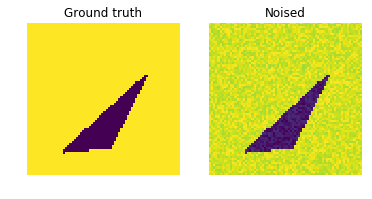

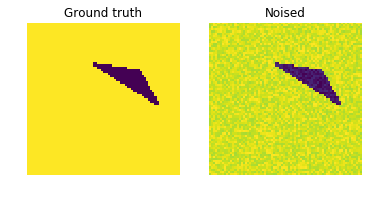

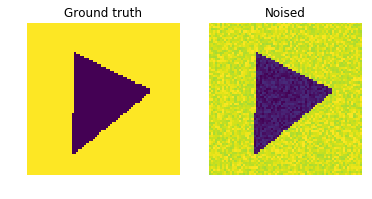

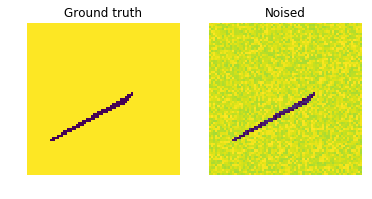

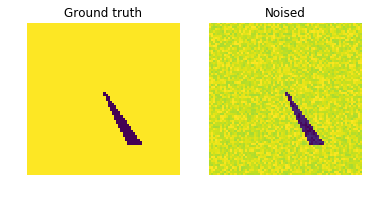

In [8]:
Y_train, _ = generate_dataset_regression(10000, 0)
Y_test, _ = generate_dataset_regression(300, 0)

noise = 20. / 255.
X_train = Y_train + noise * (2 * np.random.random(Y_train.shape) - 1)
X_train = (X_train + noise) / (1. + 2 * noise)
X_test = Y_test + noise * (2 * np.random.random(Y_test.shape) - 1)
X_test = (X_test + noise) / (1. + 2 * noise)

for i in range(5):
    ind = np.random.randint(len(X_train))
    plt.subplot(121)
    plt.imshow(Y_train[ind].reshape((72, 72)))
    plt.axis("off")
    plt.title("Ground truth")
    plt.subplot(122)
    plt.imshow(X_train[ind].reshape((72, 72)))
    plt.axis("off")
    plt.title("Noised")
    plt.show()

############################
### Optimizer : adadelta ###
############################
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 5184)         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72, 72, 1)    0           input_features[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 72, 72, 16)   160         reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 72, 72, 16)   64          conv2d[0][0]                     
______________________

Epoch 7/10
10000/10000 [==============================] - 29s 3ms/step - loss: 1.8033e-05 - val_loss: 1.5248e-05
Epoch 8/10
10000/10000 [==============================] - 29s 3ms/step - loss: 1.4974e-05 - val_loss: 1.2419e-05
Epoch 9/10
10000/10000 [==============================] - 29s 3ms/step - loss: 1.2564e-05 - val_loss: 1.0794e-05
Epoch 10/10
10000/10000 [==============================] - 29s 3ms/step - loss: 1.1249e-05 - val_loss: 9.1983e-06


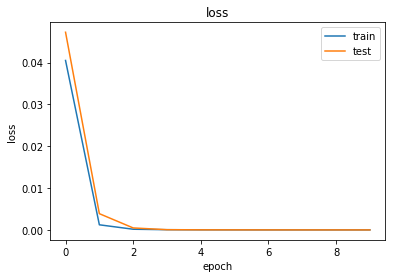

In [9]:
model = run("adadelta", "build_denoiser", X_train, Y_train, validation_data = (X_test, Y_test),
            epochs = 10, batch_size = 64, showweights = False, testnewdata = False,  verbose = True)

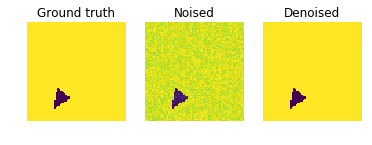

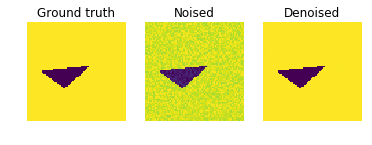

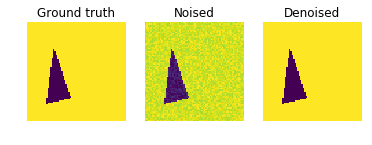

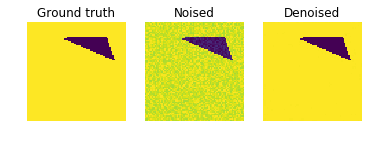

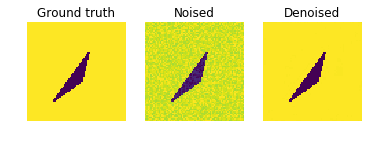

In [11]:
preds = model.predict(X_test)

for i in range(5):
    ind = np.random.randint(len(X_test))
    plt.subplot(131)
    plt.imshow(Y_test[ind].reshape((72, 72)))
    plt.title("Ground truth")
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(X_test[ind].reshape((72, 72)))
    plt.title("Noised")
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(preds[ind].reshape((72, 72)))
    plt.title("Denoised")
    plt.axis("off")
    plt.show()

Notre denoiser fonctionne donc bien visuellement, et la loss de validation suit bien celle d'entrainement. C'est un Unet, avec des skip connections après les opérations d'upsampling pour ne pas perdre d'information à cette étape.